In [44]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [3]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [4]:
data = files[b'data']
labels = files[b'labels']

In [5]:
data.shape

(10000, 3072)

In [6]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

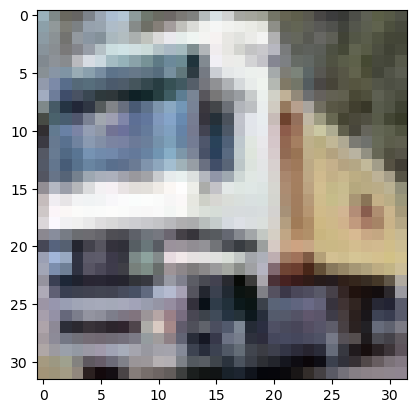

In [7]:
imshow(data[1])

In [8]:
labels[1]

9

In [9]:
classes[labels[1]]

'truck'

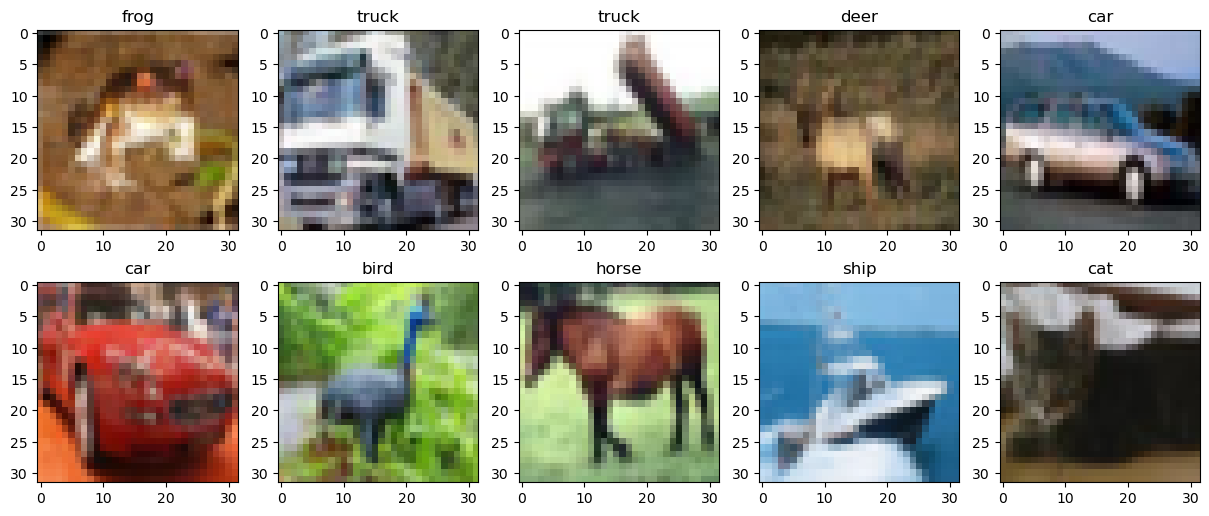

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
idx=0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

In [11]:
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)

In [48]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Konstruktor
    def __init__(self):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten

        # Convolutional Layer
        # die erste 3 bedeutet, dass wir 3 Farbkanäle haben
        # die 32 bedeutet, dass wir 32 Filter verwenden
        # die letzte 3 bedeutet, dass wir 3x3 Filter verwenden
        self.conv1 = torch.nn.Conv2d(3, 32, 3)

        # 32: 32 Features gehen rein
        # 64: 64 Features gehen raus
        # 3: Filtergräße 3x3
        # padding 1: Außen um das Bild eine Reihen mit Nullen
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1, stride=2)


        # stride 2: springe mit dem Filter immer zwei Felder weiter (default 1)
        self.conv3 = torch.nn.Conv2d(64, 212, 3, padding=1, stride=2)

        self.fc = torch.nn.Linear(212*8*8, 10)

        self.bn1 = torch.nn.BatchNorm1d(212*8*8)

    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)  # ---> 3x32x32

        xb = self.conv1(xb)
        #print("conv1", xb.shape)   # ---> 32x30x30
        xb = torch.nn.functional.relu(xb)

        xb = self.conv2(xb)
        #print("conv2", xb.shape)  # ---> 64x15x15
        xb = torch.nn.functional.relu(xb)

        xb = self.conv3(xb)
        #print("conv3", xb.shape)  # ---> 212x8x8
        xb = torch.nn.functional.relu(xb)

        # flatten
        xb = xb.view(xb.size(0), -1)
        #print("flatten", xb.shape)
        xb = self.bn1(xb)
        xb = self.fc(xb)
        xb = torch.nn.functional.relu(xb)
        return xb



In [49]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

def get_accuracy(x, y):
    preds = model(x)
    preds = torch.argmax(preds, dim=1)
    correct=sum(preds == y)
    return correct.item()/len(x)

model = MySimpleNN().to(device)
xb, yb = next(get_batch(X_train, y_train, 64))
model(xb).shape

torch.Size([64, 10])

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [51]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
# eigenes Modell wird erstellt
model = MySimpleNN().to(device)
lr=0.01
# trainiere immer mit 10 Datensätzen auf einmal
batch_size=128

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    with torch.no_grad():
        # Iteration über alle Parameter im Modell
        for param in model.parameters():
            # Backpropagation, d.h. die Veränderung der Gewichte in Abhängigkeit der Ableitung
            param -= lr * param.grad
        # Alle Gradients im Modell werden auf 0 gesetzt
        model.zero_grad()
    return loss.item()

losses=[]
valid_accuracies=[]
batch_count=len(X_train)//batch_size
# import tqdm notebook
from tqdm.notebook import tqdm
for epoch in tqdm(range(100)):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(X_train, y_train, batch_size):
        loss_sum+=train(xb, yb)
    losses.append(loss_sum/batch_count)
    valid_accuracies.append(get_accuracy(X_test, y_test))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses, label="loss")
plt.plot(valid_accuracies, label="valid_acc")
plt.legend()

In [ ]:
get_accuracy(X_test, y_test)